# Animate Simulation

This notebook is used to animate the simulation.

In [51]:
import numpy as np
import pandas as pd
import scipy as sp

In [52]:
from simulation import NetworkSimulation

from environment import Environment
from location import Location

from importlib import reload
from matplotlib import animation, rc
from IPython.display import HTML

In [53]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from msci.utils import utils
from msci.utils.plot import plot_histogram_jn, plot_path_jn

In [56]:
import copy
import datetime

from scipy.stats import gaussian_kde

In [57]:
from tqdm import tqdm_notebook as tqdm

## Setup the environment

The environement is an object which contains an area. The area is a list of lists.

### Create environment

In [58]:
shop_df = utils.import_shop_directory(mall='Mall of Mauritius', version=2)
shop_df.centroid = shop_df.centroid.apply(lambda x: x[1:-1].split(','))

In [59]:
shop_df.head()

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661
2,46538,B48,629.000000,"{128.0: [120.0, 131.0], 129.0: [119.0, 121.0],...","[118.1652126577564, 125.09122652456057]",118.165213,125.091227,4464
3,30784,B251,611.500000,"{256.0: [51.0, 58.0], 256.5: [52.0, 56.5], 258...","[266.81200190575197, 46.96101871101871]",266.812002,46.961019,5449
4,23494,B39,1718.500000,"{18.0: [102.0, 103.0], 19.0: [102.0, 103.0], 2...","[50.058532675009225, 106.37523764932889]",50.058533,106.375238,4711


In [60]:
environment_ = Environment(shop_df)

HBox(children=(IntProgress(value=0, max=126), HTML(value='')))

### Get Real Data - shoppers & mac addresses

In [61]:
mac_address_df = utils.import_mac_addresses(version=3)
signal_df = utils.import_signals(version=4)

/Users/SebastianLee/.virtualenvs/venv-msci/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [62]:
shopper_df = mac_address_df[mac_address_df.dbscan_label == 'Shopper']

In [63]:
shopper_df.start_time = pd.to_datetime(shopper_df.start_time)

/Users/SebastianLee/.virtualenvs/venv-msci/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


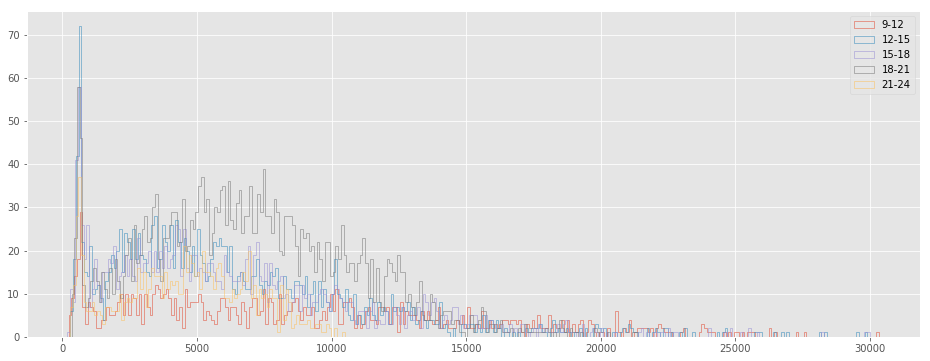

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 100

data = shopper_df[
    (pd.datetime(2016, 12, 22, 9) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 12) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='9-12');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 12) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 15) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='12-15');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 15) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 18) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='15-18');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 18) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 22, 21) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='18-21');

data = shopper_df[
    (pd.datetime(2016, 12, 22, 21) < shopper_df.start_time) &
    (pd.datetime(2016, 12, 23, 0) > shopper_df.start_time)
].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='21-24');

ax.legend();

### Initiate the simulation

In [65]:
start_date_time = datetime.datetime(year=2016, month=12, day=22, hour=9)
end_date_time = datetime.datetime(year=2016, month=12, day=23, hour=0)

In [66]:
environment = copy.deepcopy(environment_)

In [100]:
sim = NetworkSimulation(environment, max_shoppers=9000, start_date_time=start_date_time, end_date_time=end_date_time)

In [101]:
shop_markov_data = np.load('shop_markov_data.npz')

In [102]:
sim.A, sim.pi = environment.realign_transition_matrix(
    shop_markov_data['shop_names'], 
    shop_markov_data['transition_matrix'].T,
    shop_markov_data['initial_probabilities'],
)

In [103]:
print(sim.A)

[[  9.04024000e-01   3.84300697e-03   8.42982173e-04 ...,   4.95871867e-05
    0.00000000e+00   2.47935933e-05]
 [  4.30077691e-02   3.71809101e-01   3.88457270e-03 ...,   0.00000000e+00
    0.00000000e+00   2.77469478e-04]
 [  8.63131936e-03   3.69913687e-03   6.92795491e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.00000000e-01   1.00000000e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


### Create the distributions

In [104]:
length_of_stay_distribution = gaussian_kde((shopper_df.length_of_stay / 60).as_matrix())

In [105]:
arrival_distribution = gaussian_kde(
    (pd.to_datetime(shopper_df.start_time) - start_date_time).dt.round('15min').dt.total_seconds().as_matrix()
)

In [106]:
sim.length_of_stay_distribution = length_of_stay_distribution
sim.arrival_distribution = arrival_distribution

## Run the simulation

The simulation requires the maximum number of iterations (time) and the maximum number of shoppers (agents).

In [107]:
sim.iterate(max_iterations=1000)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

## Histograms comparing actual vs simulated shoppers

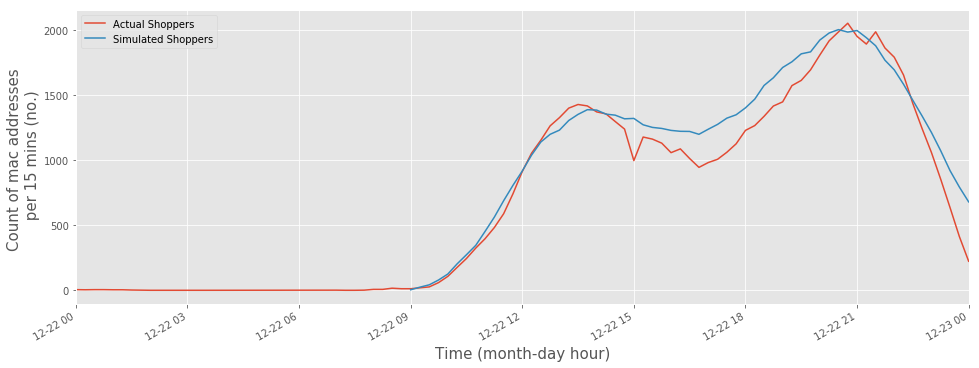

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(shopper_df.mac_address)], 
    axes=ax,
    label='Actual Shoppers',
)

plot_histogram_jn(
    sim.signal_df, 
    axes=ax,
    label='Simulated Shoppers',
);

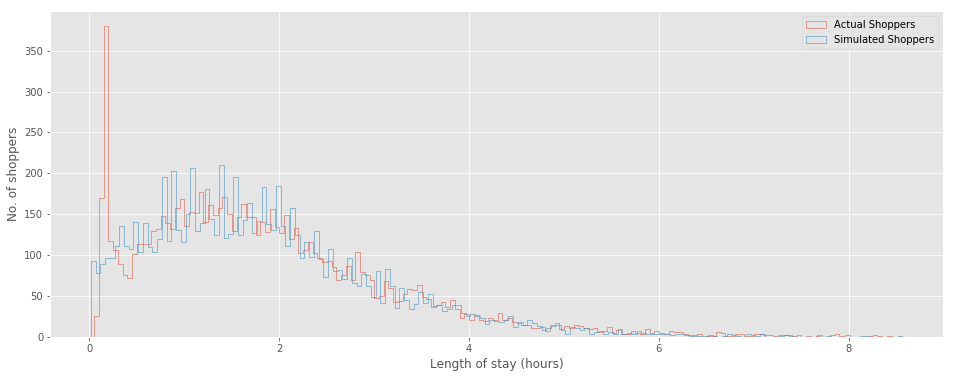

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.05

data = (shopper_df.length_of_stay / 60 / 60).as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers');

data = (sim.mac_address_df.length_of_stay / 60 / 60).as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Length of stay (hours)')

ax.legend();

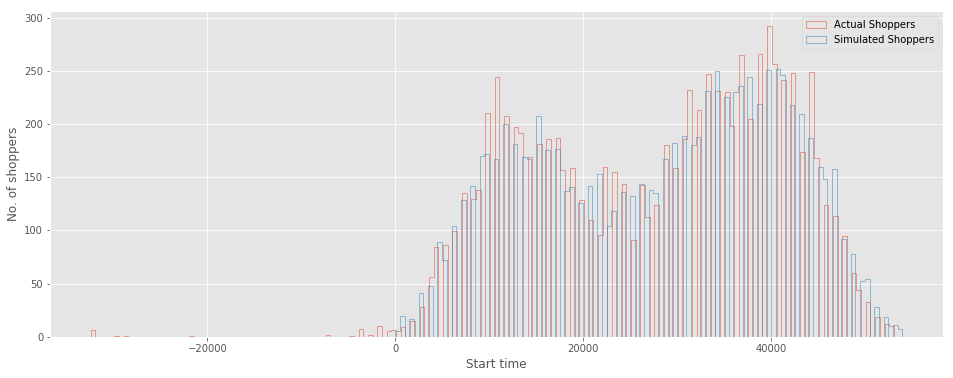

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 500

start_time = min(pd.to_datetime(sim.mac_address_df.start_time))

data = (pd.to_datetime(shopper_df.start_time) - start_time).dt.round('15min').dt.total_seconds()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers')


data = (pd.to_datetime(sim.mac_address_df.start_time) - start_time).dt.round('15min').dt.total_seconds()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Start time')

ax.legend();

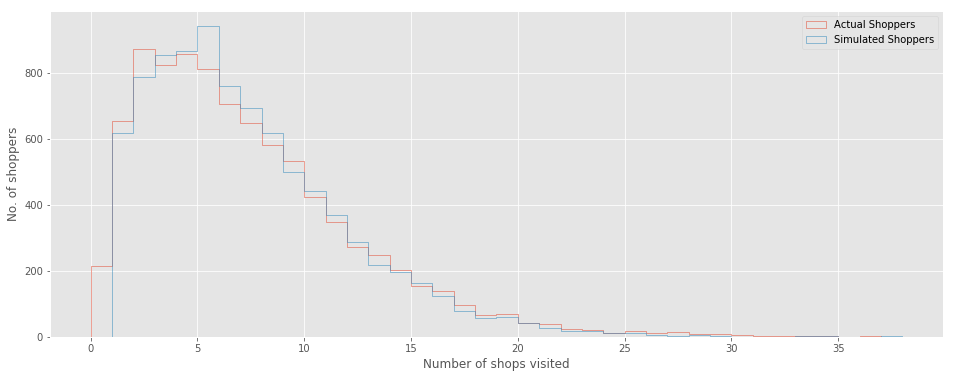

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = shopper_df.number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers')

data = sim.mac_address_df.number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Number of shops visited')

ax.legend();

## Extract features

In [78]:
from msci.cleaning.features import calculate_radius_gyration, calculate_straightness, calculate_turning_angle

In [79]:
sim.mac_address_df['centroid'], sim.mac_address_df['radius_of_gyration'] = \
    calculate_radius_gyration(sim.signal_df, sim.mac_address_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=8771), HTML(value='')))

In [80]:
r_signal_df = pd.merge(
    signal_df[
        signal_df.store_id.notnull() & 
        (signal_df.store_id.str[0] == 'B') & 
        signal_df.mac_address.isin(shopper_df.mac_address)
    ], 
    shop_df[['store_id', 'x', 'y']], 
    on='store_id', 
    how='left',
    suffixes=('_actual', '')
)

r_shopper_df = shopper_df[shopper_df.mac_address.isin(r_signal_df.mac_address)]

In [81]:
r_shopper_df['centroid'], r_shopper_df['radius_of_gyration'] = \
    calculate_radius_gyration(r_signal_df, r_shopper_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Radius of Gyration', max=8714), HTML(value='')))

/Users/SebastianLee/.virtualenvs/venv-msci/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


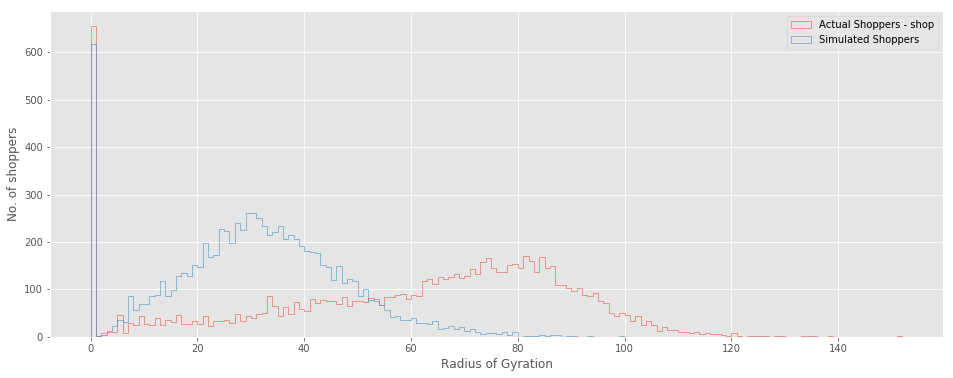

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = r_shopper_df[r_shopper_df.radius_of_gyration.notnull()].radius_of_gyration.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.radius_of_gyration.notnull()].radius_of_gyration.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Radius of Gyration')

ax.legend();

In [83]:
def probability_of_moving_forwards(signal_df, mac_address_df, remove_consecutive=False):
    signal_sorted_df = signal_df.sort_values('date_time')
    signal_mac_group = signal_sorted_df.groupby('mac_address')
    macs = mac_address_df.mac_address.tolist()
    probabilities = []
    for mac in tqdm(macs, desc='Forwards Probability'):
        mac_signals_df = signal_mac_group.get_group(mac)
        if remove_consecutive:
            mac_signals_df = mac_signals_df.loc[mac_signals_df.store_id.shift(-1) != mac_signals_df.store_id]
        r = mac_signals_df[['x', 'y']].as_matrix()
        prob = np.nan
        if len(r) > 2:
            direction = r[1:] - r[:-1]
            direction = direction[np.any(direction != 0, axis=1)]
            if len(direction) > 1:
                r1r2 = np.array([np.dot(i, j) for i, j in zip(direction[1:], direction[:-1])])
                prob = len(np.where(r1r2 > 0)[0]) / len(r1r2)
        probabilities.append(prob)
    return probabilities

In [84]:
r_shopper_df['prob_forwards'] = probability_of_moving_forwards(r_signal_df, r_shopper_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Forwards Probability', max=8714), HTML(value='')))

/Users/SebastianLee/.virtualenvs/venv-msci/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [85]:
sim.mac_address_df['prob_forwards'] = probability_of_moving_forwards(sim.signal_df, sim.mac_address_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Forwards Probability', max=8771), HTML(value='')))

In [86]:
r_shopper_df['av_turning_angle'], r_shopper_df['total_turning_angle'], r_shopper_df['av_turning_angle_velocity'] = \
    calculate_turning_angle(r_signal_df, r_shopper_df, remove_consecutive=True)
    
sim.mac_address_df['av_turning_angle'], sim.mac_address_df['total_turning_angle'], sim.mac_address_df['av_turning_angle_velocity'] = \
    calculate_turning_angle(sim.signal_df, sim.mac_address_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Turning Angle', max=8714), HTML(value='')))

/Users/SebastianLee/Documents/Repos/msci-complexity-project/msci/cleaning/features.py:187: RuntimeWarning: invalid value encountered in arccos
  mac_turning_angles = np.arccos(cos_angle)
/Users/SebastianLee/Documents/Repos/msci-complexity-project/msci/cleaning/features.py:188: RuntimeWarning: Mean of empty slice
  av_turning_angle = np.nanmean(mac_turning_angles)
/Users/SebastianLee/Documents/Repos/msci-complexity-project/msci/cleaning/features.py:193: RuntimeWarning: Mean of empty slice
  av_turning_angle_velocity = np.nanmean(mac_turning_angle_velocities)


/Users/SebastianLee/.virtualenvs/venv-msci/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


HBox(children=(IntProgress(value=0, description='Turning Angle', max=8771), HTML(value='')))

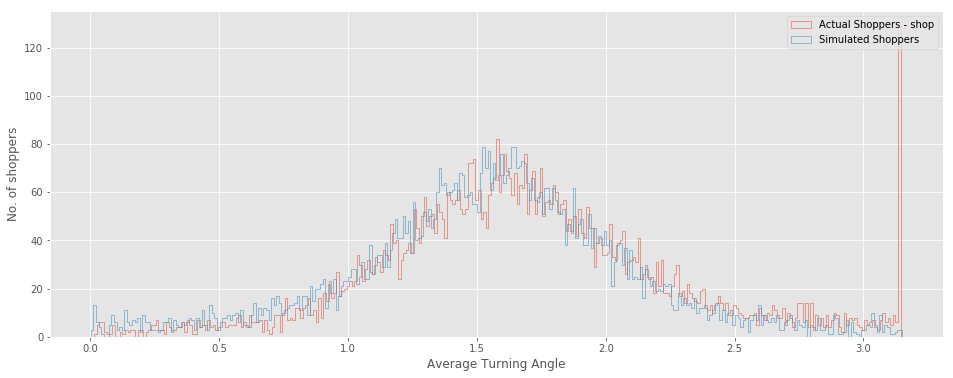

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.01

data = r_shopper_df[r_shopper_df.av_turning_angle.notnull()].av_turning_angle.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.av_turning_angle.notnull()].av_turning_angle.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Average Turning Angle')

ax.legend();

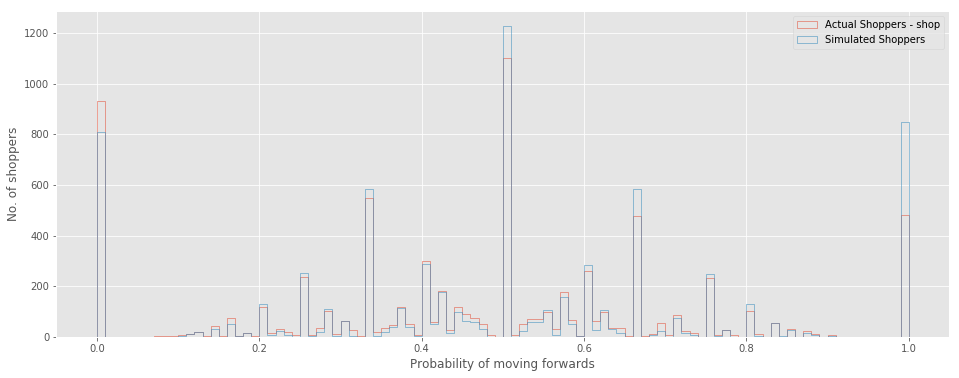

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.01

data = r_shopper_df[r_shopper_df.prob_forwards.notnull()].prob_forwards.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.prob_forwards.notnull()].prob_forwards.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Probability of moving forwards')

ax.legend();

In [89]:
r_shopper_df['av_straightness'] = calculate_straightness(r_signal_df, r_shopper_df, remove_consecutive=True)
sim.mac_address_df['av_straightness'] = calculate_straightness(sim.signal_df, sim.mac_address_df, remove_consecutive=True)

HBox(children=(IntProgress(value=0, description='Straighness', max=8714), HTML(value='')))

/Users/SebastianLee/Documents/Repos/msci-complexity-project/msci/cleaning/features.py:268: RuntimeWarning: divide by zero encountered in true_divide
  mac_path_lengths = (mod(u) + mod(v)) / mod(t)
/Users/SebastianLee/Documents/Repos/msci-complexity-project/msci/cleaning/features.py:270: RuntimeWarning: Mean of empty slice
  av_straightness = np.nanmean(mac_path_lengths)


/Users/SebastianLee/.virtualenvs/venv-msci/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


HBox(children=(IntProgress(value=0, description='Straighness', max=8771), HTML(value='')))

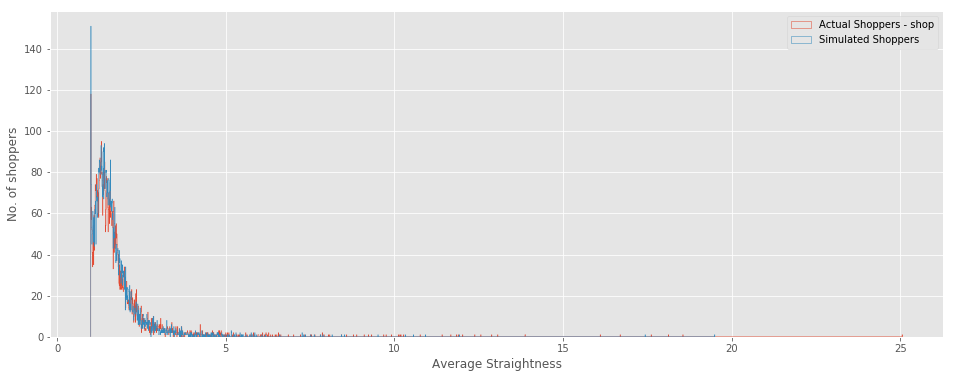

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 0.01

data = r_shopper_df[r_shopper_df.av_straightness.notnull()].av_straightness.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Actual Shoppers - shop')

data = sim.mac_address_df[sim.mac_address_df.av_straightness.notnull()].av_straightness.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Simulated Shoppers');

ax.set_ylabel('No. of shoppers')
ax.set_xlabel('Average Straightness')

ax.legend();

In [108]:
def add_count_of_shoppers(signal_df, shop_df):
    count_of_shoppers = []
    signal_group = signal_df.groupby('store_id')
    for shop in tqdm(shop_df.store_id.tolist(), desc='Count of shoppers'):
        try:
            group = signal_group.get_group(shop)
            count_of_shoppers.append(len(group.mac_address.unique()))
        except:
            count_of_shoppers.append(np.nan)
    return count_of_shoppers

In [109]:
shop_df['sim_count'] = add_count_of_shoppers(sim.signal_df, shop_df)
shop_df['act_count'] = add_count_of_shoppers(r_signal_df, shop_df)

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Count of shoppers', max=126), HTML(value='')))

In [110]:
from scipy.stats import linregress

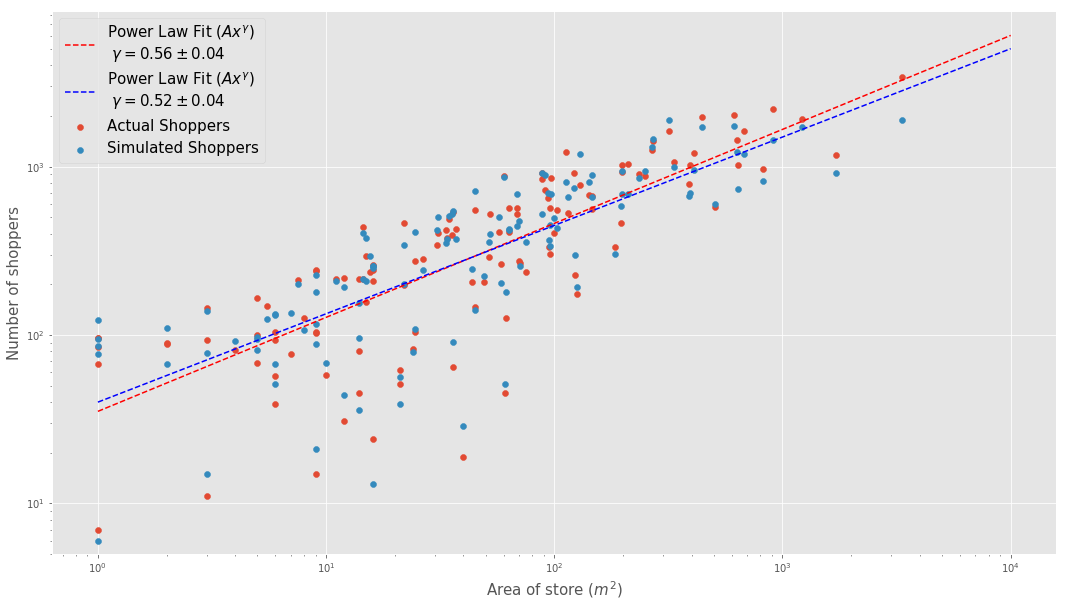

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

area_shop_df = shop_df[
    (shop_df.area > 0) & 
    (shop_df.act_count > 0) & 
    (shop_df.sim_count > 0) &
    shop_df.sim_count.notnull()
]

ax.scatter(area_shop_df.area, area_shop_df.act_count, label='Actual Shoppers')
slope, intercept, x_value, p_value, std_err = linregress(
    np.log10(area_shop_df.area), np.log10(area_shop_df.act_count)
)
area_fit = np.linspace(1, 10**4, 10)
count_of_shoppers_fit = [10**intercept*x**slope for x in area_fit]
ax.plot(
    area_fit, count_of_shoppers_fit, 'r--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.scatter(area_shop_df.area, area_shop_df.sim_count, label='Simulated Shoppers')
slope, intercept, x_value, p_value, std_err = linregress(
    np.log10(area_shop_df.area), np.log10(area_shop_df.sim_count)
)
area_fit = np.linspace(1, 10**4, 10)
count_of_shoppers_fit = [10**intercept*x**slope for x in area_fit]
ax.plot(
    area_fit, count_of_shoppers_fit, 'b--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of store ($m^2$)', fontsize=15)
ax.set_ylabel('Number of shoppers', fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(fontsize=15);

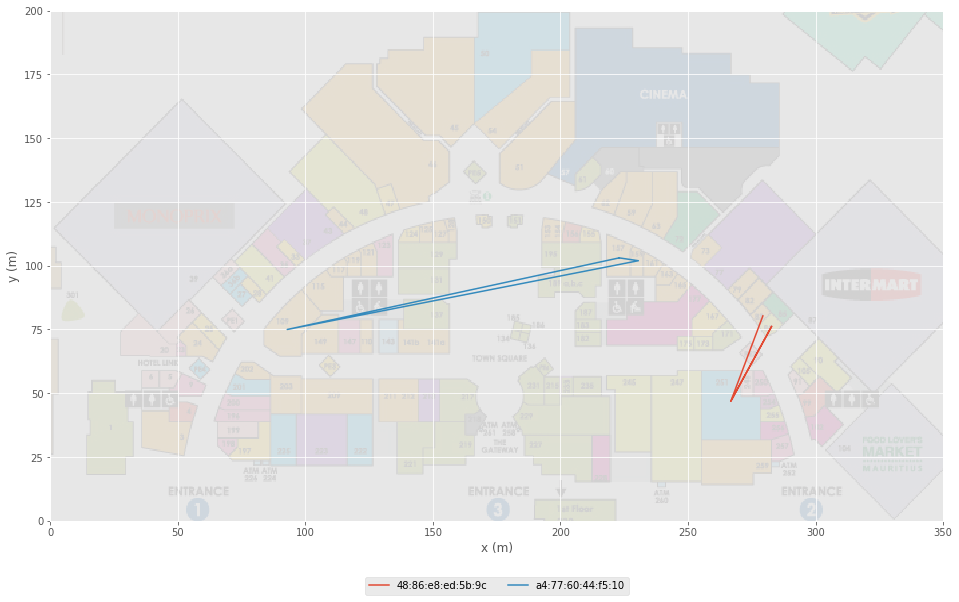

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    r_signal_df, 
    r_shopper_df[r_shopper_df.av_straightness > 10][3:5],
    axes=ax, 
    plot_type='', 
    label='Low Straighness'
)

# plot_path_jn(
#     r_signal_df, 
#     r_shopper_df[r_shopper_df.av_straightness > 3][:1],
#     axes=ax, 
#     plot_type='', 
#     label='High Straighness'
# )

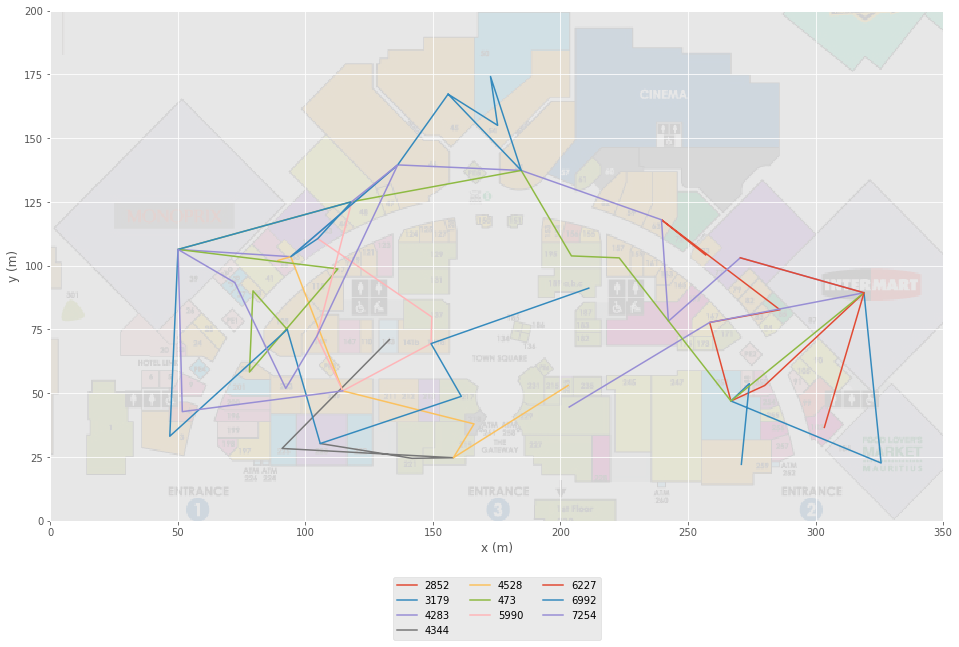

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    sim.signal_df, 
    sim.mac_address_df[sim.mac_address_df.av_straightness < 2][:10],
    axes=ax, 
    plot_type='', 
    label='Low Straighness'
)

# plot_path_jn(
#     sim.signal_df, 
#     sim.mac_address_df[sim.mac_address_df.av_straightness > 3][:1],
#     axes=ax, 
#     plot_type='', 
#     label='High Straighness'
# )

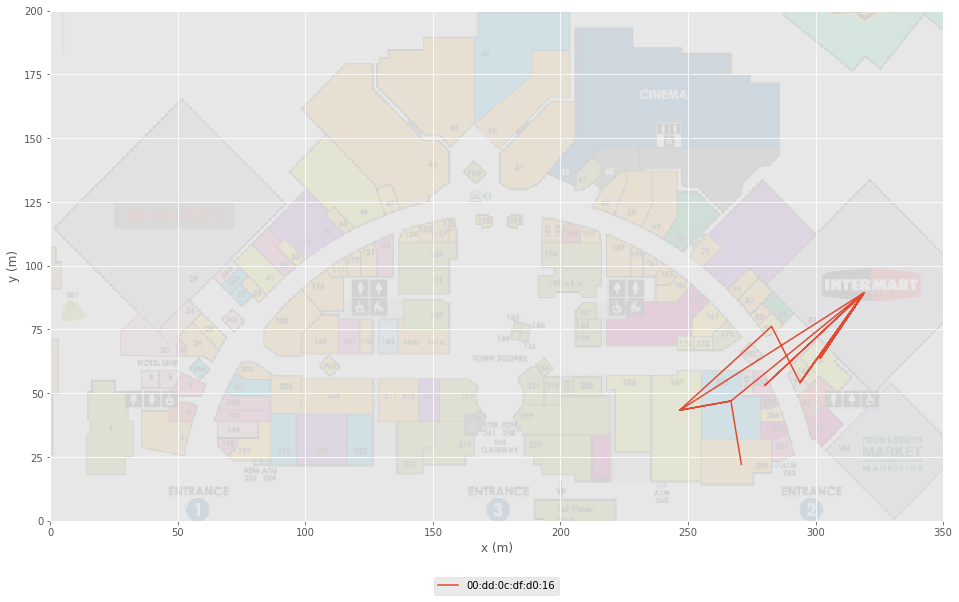

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    r_signal_df, 
    r_shopper_df[r_shopper_df.prob_forwards < 0.1][3:4],
    axes=ax, 
    plot_type='', 
    label='Low Straighness'
)

# plot_path_jn(
#     r_signal_df, 
#     r_shopper_df[r_shopper_df.radius_of_gyration < 20][:10],
#     axes=ax, 
#     plot_type='', 
#     label='Low Straighness'
# )


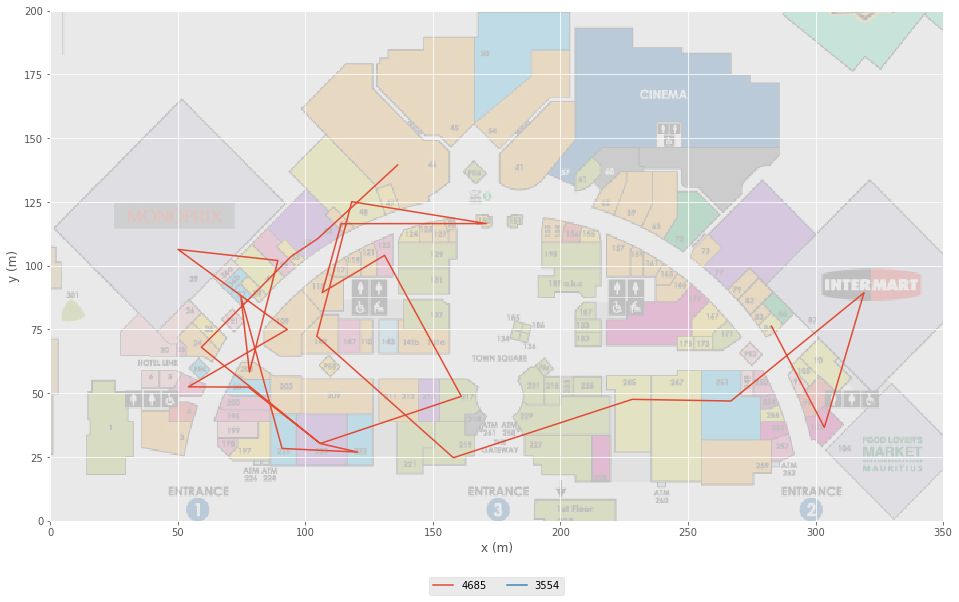

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    sim.signal_df, 
    sim.mac_address_df[sim.mac_address_df.radius_of_gyration > 80][3:4],
    axes=ax, 
    plot_type='', 
    label='Low Straighness'
)

plot_path_jn(
    sim.signal_df, 
    sim.mac_address_df[sim.mac_address_df.radius_of_gyration < 20][:1],
    axes=ax, 
    plot_type='', 
    label='High Straighness'
)